## Install/Use MetaSeg Package

https://github.com/kadirnar/segment-anything-video

MetaSeg is under heavy development so API is changing.

In [21]:
!nvidia-smi

Thu Apr 13 14:35:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |  10645MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
!pip install metaseg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

## Get test dataset

In [25]:
!git clone https://github.com/saschwarz/yolov8-bbox-segment-anything.git

fatal: destination path 'yolov8-bbox-segment-anything' already exists and is not an empty directory.


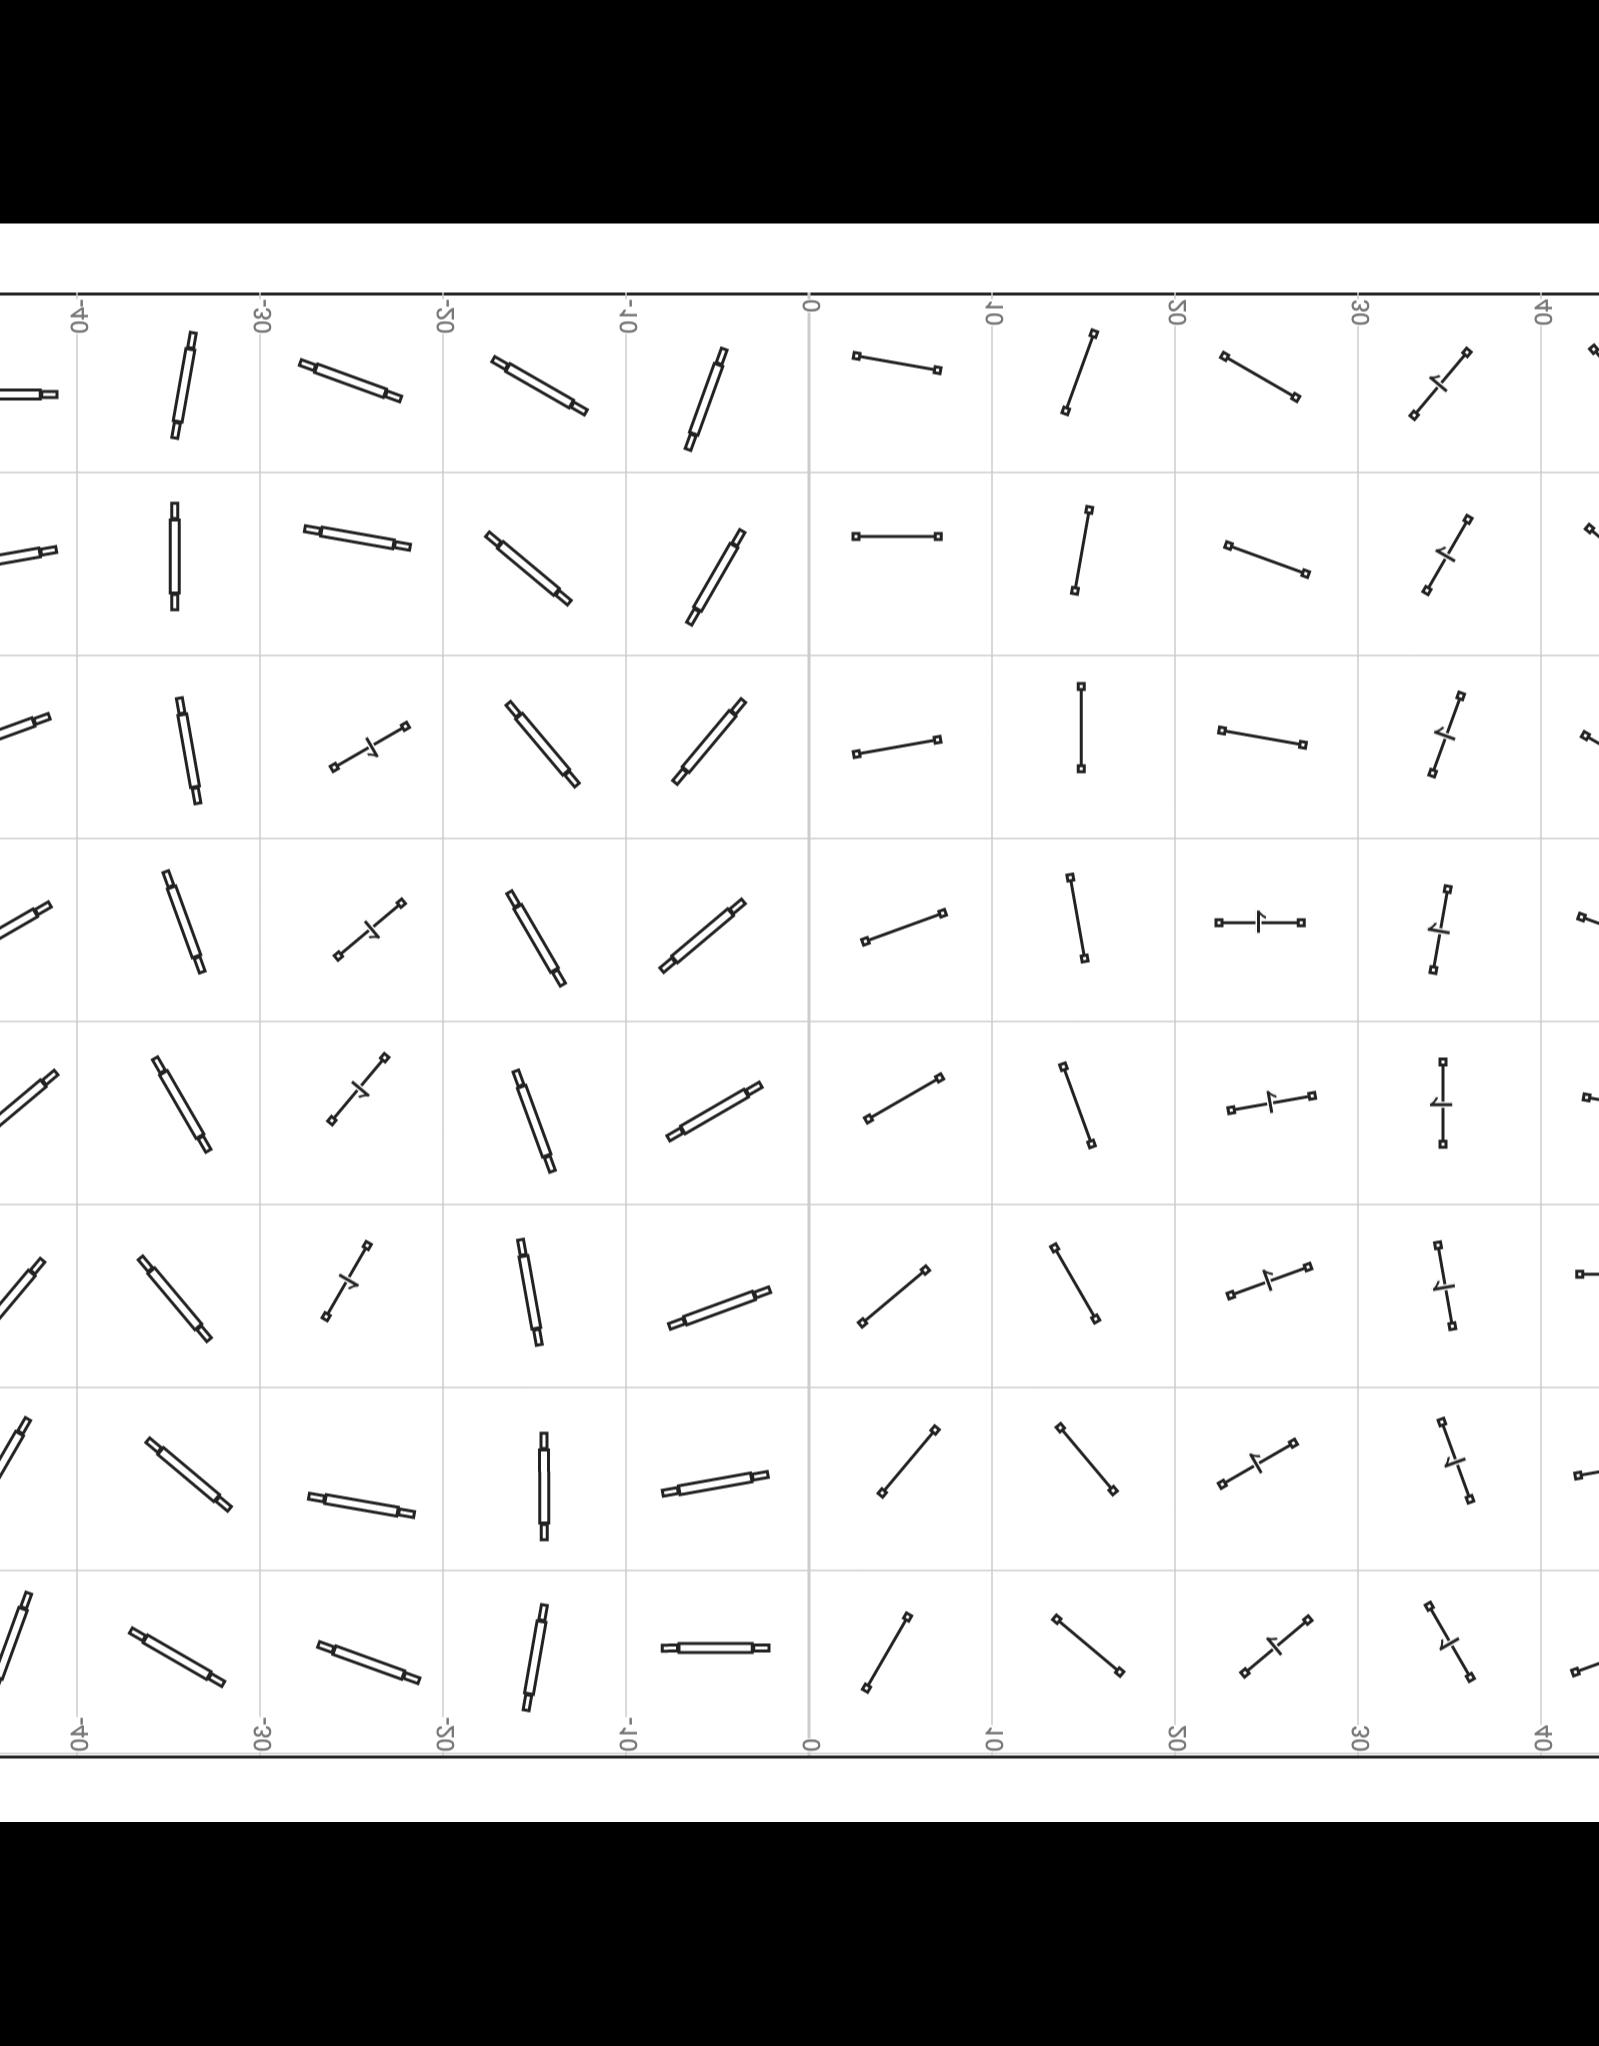

In [26]:
from IPython.display import Image
Image("/content/yolov8-bbox-segment-anything/dataset/test/images/jumps-2_277303_png.rf.83ecc0ce51aec854b221952d5c1ecccb.jpg")

## Use MetaSeg on One Image

In [ ]:
results = codeautoseg_image = SegAutoMaskPredictor().image_predict(
    source="/content/yolov8-bbox-segment-anything/dataset/test/images/jumps-2_277303_png.rf.83ecc0ce51aec854b221952d5c1ecccb.jpg",
    model_type="vit_l",
    points_per_side=32, 
    points_per_batch=64,
    min_area=0,
    output_path="output.jpg",
    save=True
)
# print(results)
Image("output.jpg")

## Apply MetaSeg to Image

In [32]:
!pip install globox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
from globox import AnnotationSet
import json

gts = AnnotationSet.from_yolo_v7(    
    folder="/content/yolov8-bbox-segment-anything/dataset/test/labels",
    image_folder="/content/yolov8-bbox-segment-anything/dataset/test/images")

# gts.show_stats()

for filename, annotation in gts.items():
  print(filename, annotation.image_width, annotation.image_height)
  # for annotation in image.annotations:
  #   print(annotation)

txt_path = "/content/yolov8-bbox-segment-anything/dataset/test/labels/jumps-2_277303_png.rf.83ecc0ce51aec854b221952d5c1ecccb.txt"
# with open(txt_path) as annotations:
#   for line in annotations:
#     # bounding box annotations are classname, centerx, centery, widht, height
#     # with values from 0 to 1
#     name, cx, cy, w, h = line.split()
#     x, y = float(cx), float(cy)
#     hx, hy = float(w), float(h), 
#     input = [x - hx/2, y - hy/2, x + hx/2, y + hy/2]
#     print(input)

# result = SegManualMaskPredictor().save_image(
#     source="test.jpg",
#     model_type="vit_l",
#     input_point=None,
#     input_label=None,
#     input_box= [input],
#     multimask_output=False,
# )

# Image(result)

jumps-2_277303_png.rf.83ecc0ce51aec854b221952d5c1ecccb.jpg 1599 2046
